The goal of this project is to conduct algorithmic trading using supervised learning approaches. The dataset is given by Dr. Xin Tong, a professor of DSO 530 class at USC Marshall. Each table is the daily stock data of 50 companies from Day 1 to Day 756 (in the years 2017-2019), which are constituents of the SSE 50 index. The data of one day includes open, high, low, volume, and close prices.

In this notebook, I develop a regression model to predict the prices of the 50 stocks for the next day. I use the data from Day 1 to Day 504 only for model building since I will simulate and test the algorithm assuming that I start trading on Day 505.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go

start_time = datetime.now()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [4]:
stocklist = ['SH600000', 'SH600010', 'SH600015', 'SH600016', 'SH600018', 'SH600028', 'SH600030', 'SH600036', 'SH600048', 'SH600050', 'SH600089', 'SH600104', 'SH600109', 'SH600111', 'SH600150', 'SH600256', 'SH600406', 'SH600518', 'SH600519', 'SH600583', 'SH600585', 'SH600637', 'SH600690', 'SH600837', 'SH600887', 'SH600893', 'SH600958', 'SH600999', 'SH601006', 'SH601088', 'SH601166', 'SH601169', 'SH601186', 'SH601288', 'SH601318', 'SH601328', 'SH601390', 'SH601398', 'SH601601', 'SH601628', 'SH601668', 'SH601688', 'SH601766', 'SH601800', 'SH601818', 'SH601857', 'SH601901', 'SH601988', 'SH601989', 'SH601998']

In [5]:
data = pd.read_csv('/content/drive/My Drive/3. USC/2. Spring 2020/DSO530 ML/project/raw data 17-19/'+stocklist[0]+'.csv')
data

,Time,Open,High,Low,Close,Volume
0,Day1,154.6414,159.7405,154.4560,156.9592,45036400
1,Day2,156.9592,158.7207,156.3102,156.5883,21043100
2,Day3,156.5883,158.5353,155.8467,158.4426,23335200
3,Day4,158.9988,162.1510,158.9988,159.5551,33835300
4,Day5,159.5551,160.8530,158.6280,160.0186,29530100
...,...,...,...,...,...,...
751,Day752,157.8890,159.6702,157.5073,158.0162,40150148
752,Day753,158.5252,158.5252,154.8356,155.2172,37033892
753,Day754,155.3445,156.3623,155.2172,156.2351,21671028
754,Day755,156.3623,156.3623,155.2172,155.7262,13678175


In [6]:
data.describe()

,Open,High,Low,Close,Volume
count,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,145.109758,146.357426,143.873642,145.092134,3.753013e+07
std,12.643616,12.783442,12.590226,12.705936,3.364268e+07
min,113.066900,114.165800,111.968000,113.066900,7.996800e+06
25%,135.607700,136.348000,134.096150,135.021550,1.909316e+07
50%,148.457300,149.774100,147.074700,148.342050,2.737580e+07
75%,154.835600,156.112050,153.971200,155.026750,4.113931e+07
max,168.448900,171.187600,165.777100,168.013000,3.796536e+08


In [7]:
data.isna().sum()

Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

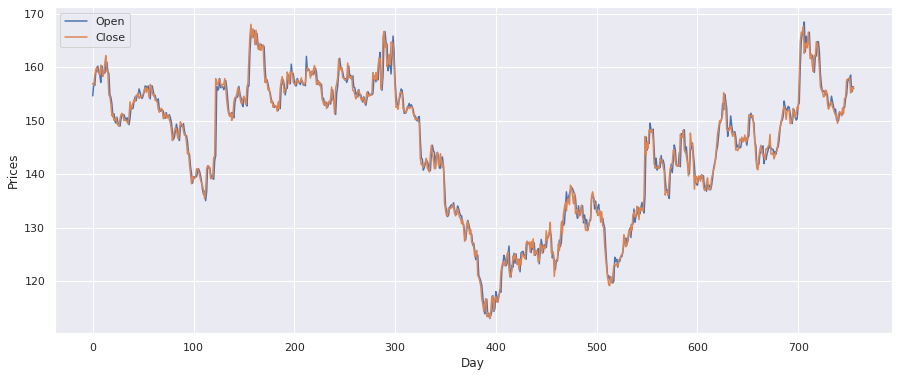

In [8]:
sns.set()

plt.figure(figsize = (15, 6))
plt.plot(data['Open'], label='Open')
plt.plot(data['Close'], label='Close')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

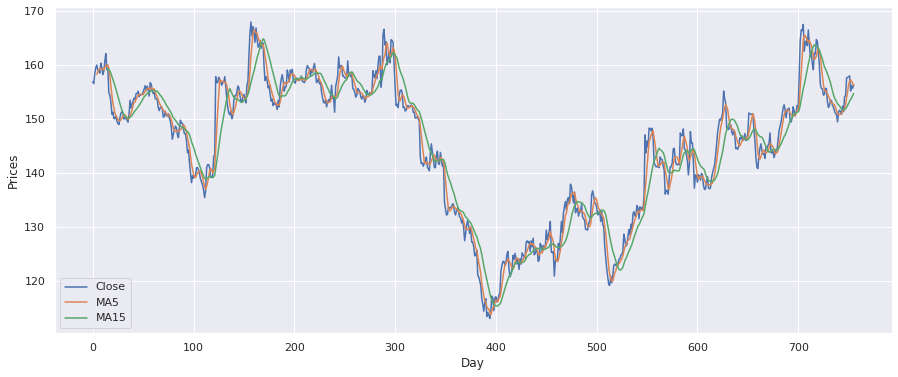

In [9]:
# Moving Average Plot
plt.figure(figsize = (15, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['Close'].rolling(5).mean(), label='MA5')
plt.plot(data['Close'].rolling(15).mean(), label='MA15')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.show()

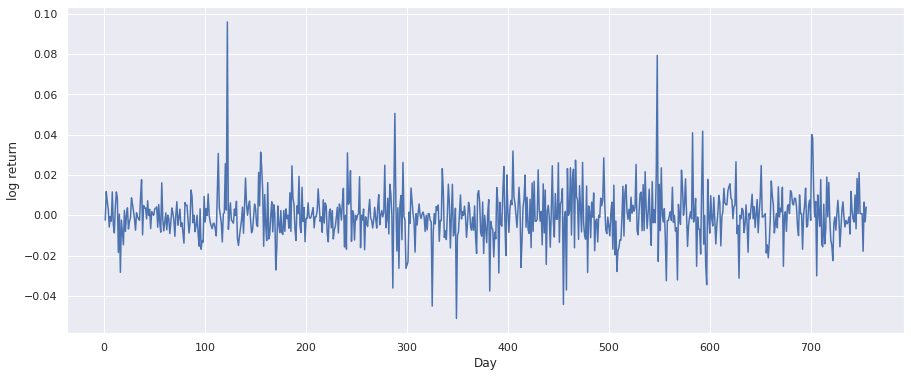

In [10]:
# Log return plot
plt.figure(figsize = (15, 6))
plt.plot(np.log(data.Close) - np.log(data.Close.shift(1)))
plt.xlabel('Day')
plt.ylabel('log return')
plt.show()

## Data Exploring

Before moving onto the feature engineering phase, I first obtain some descriptive statistics on the dataset to get a general sense of the numbers. I also build a 'risk_table' with rolling standard deviations, which will later be used for the trading algorithm.

In [11]:
risk_table = pd.DataFrame()
eda = pd.DataFrame()
return_table = pd.DataFrame()

for stock in stocklist:
    temp = pd.read_csv('/content/drive/My Drive/3. USC/2. Spring 2020/DSO530 ML/project/raw data 17-19/'+stock+'.csv')

    # Checking null values
    if temp.isna().sum().sum() > 0:
        print(f'{stock} has {temp.isna().sum().sum()} null values')

    # Calculating standard deviations
    temp['return'] = temp['Close']/temp['Close'].shift(1)-1
    return_table[stock] = temp['return']
    risk_table[stock+'stdev_90days'] = temp['return'].shift(1).rolling(90).std()
    risk_table[stock+'stdev_180days'] = temp['return'].shift(1).rolling(180).std()
    risk_table[stock+'stdev_cum'] = temp['return'].shift(1).rolling(len(data), min_periods=3).std()

    # EDA
    end_day = data[data.Time=='Day504'].index[0]+1
    temp = temp.iloc[:end_day,:]
    temp['return_pct'] = 100*(temp['Close']/temp['Close'].shift(1)-1)
    return_daily = temp['return_pct'].dropna().mean()
    volat_daily = temp['return_pct'].dropna().std()
    eda.loc[stock,'return_daily_pct'] = return_daily
    eda.loc[stock,'return_annualized_pct'] = ((return_daily/100+1)**252-1)*100
    eda.loc[stock,'volatility_daily_pct'] = volat_daily
    eda.loc[stock,'volatility_annualized_pct'] = volat_daily*np.sqrt(252)
    eda.loc[stock,'Sharpe_ratio'] = np.sqrt(252)*return_daily/volat_daily

return_table = return_table.iloc[1:,:]
risk_table = risk_table.iloc[end_day:,:].reset_index(drop=True)
risk_table.to_csv('/content/drive/My Drive/Colab Notebooks/Algorithmic Trading/risk.csv')

In [12]:
risk_table

,SH600000stdev_90days,SH600000stdev_180days,SH600000stdev_cum,SH600010stdev_90days,SH600010stdev_180days,SH600010stdev_cum,SH600015stdev_90days,SH600015stdev_180days,SH600015stdev_cum,SH600016stdev_90days,SH600016stdev_180days,SH600016stdev_cum,SH600018stdev_90days,SH600018stdev_180days,SH600018stdev_cum,SH600028stdev_90days,SH600028stdev_180days,SH600028stdev_cum,SH600030stdev_90days,SH600030stdev_180days,SH600030stdev_cum,SH600036stdev_90days,SH600036stdev_180days,SH600036stdev_cum,SH600048stdev_90days,SH600048stdev_180days,SH600048stdev_cum,SH600050stdev_90days,SH600050stdev_180days,SH600050stdev_cum,SH600089stdev_90days,SH600089stdev_180days,SH600089stdev_cum,SH600104stdev_90days,SH600104stdev_180days,SH600104stdev_cum,SH600109stdev_90days,SH600109stdev_180days,SH600109stdev_cum,SH600111stdev_90days,...,SH601390stdev_cum,SH601398stdev_90days,SH601398stdev_180days,SH601398stdev_cum,SH601601stdev_90days,SH601601stdev_180days,SH601601stdev_cum,SH601628stdev_90days,SH601628stdev_180days,SH601628stdev_cum,SH601668stdev_90days,SH601668stdev_180days,SH601668stdev_cum,SH601688stdev_90days,SH601688stdev_180days,SH601688stdev_cum,SH601766stdev_90days,SH601766stdev_180days,SH601766stdev_cum,SH601800stdev_90days,SH601800stdev_180days,SH601800stdev_cum,SH601818stdev_90days,SH601818stdev_180days,SH601818stdev_cum,SH601857stdev_90days,SH601857stdev_180days,SH601857stdev_cum,SH601901stdev_90days,SH601901stdev_180days,SH601901stdev_cum,SH601988stdev_90days,SH601988stdev_180days,SH601988stdev_cum,SH601989stdev_90days,SH601989stdev_180days,SH601989stdev_cum,SH601998stdev_90days,SH601998stdev_180days,SH601998stdev_cum
0,0.013757,0.013564,0.012186,0.020668,0.021200,0.018295,0.014963,0.013194,0.012073,0.012054,0.011583,0.010790,0.017754,0.015795,0.017520,0.016597,0.016494,0.014781,0.021351,0.020601,0.017433,0.020506,0.019509,0.017378,0.027145,0.028061,0.023811,0.020076,0.021133,0.024525,0.016112,0.015878,0.016242,0.021265,0.019086,0.016868,0.026009,0.024717,0.018990,0.020784,...,0.016522,0.013432,0.015209,0.013504,0.023256,0.023950,0.020683,0.017885,0.016451,0.016853,0.018698,0.017720,0.018867,0.024570,0.023792,0.019677,0.019190,0.019151,0.017208,0.026132,0.023413,0.021182,0.013453,0.012253,0.011622,0.017378,0.016533,0.013239,0.025268,0.022126,0.018834,0.010512,0.011043,0.010800,0.013116,0.015858,0.017128,0.012794,0.013904,0.014513
1,0.013814,0.013615,0.012196,0.020670,0.021215,0.018285,0.014935,0.013253,0.012087,0.011893,0.011593,0.010785,0.017627,0.015898,0.017541,0.016489,0.016501,0.014770,0.021469,0.020659,0.017445,0.020392,0.019538,0.017375,0.026898,0.028045,0.023815,0.020087,0.021142,0.024509,0.016209,0.015941,0.016253,0.021026,0.019083,0.016852,0.025987,0.024828,0.019020,0.020851,...,0.016527,0.013291,0.015216,0.013496,0.022974,0.023930,0.020680,0.017831,0.016491,0.016854,0.018629,0.017720,0.018848,0.024596,0.023931,0.019716,0.019303,0.019219,0.017218,0.025963,0.023413,0.021161,0.013283,0.012277,0.011620,0.017374,0.016533,0.013227,0.025201,0.022239,0.018866,0.010316,0.011049,0.010792,0.013057,0.015905,0.017130,0.012809,0.013913,0.014502
2,0.013890,0.013271,0.012203,0.020587,0.021219,0.018269,0.014942,0.013118,0.012076,0.011905,0.011347,0.010777,0.017635,0.015903,0.017525,0.016525,0.016533,0.014766,0.021515,0.020682,0.017439,0.020393,0.019415,0.017358,0.026824,0.027991,0.023792,0.020090,0.020570,0.024485,0.016196,0.015749,0.016237,0.020657,0.019111,0.016848,0.025966,0.024317,0.019003,0.020843,...,0.016519,0.013274,0.015098,0.013483,0.022998,0.023941,0.020664,0.017846,0.016522,0.016847,0.018511,0.017810,0.018860,0.024551,0.023423,0.019698,0.019056,0.019220,0.017201,0.025090,0.023440,0.021151,0.013267,0.012283,0.011611,0.017360,0.016408,0.013215,0.025211,0.021675,0.018850,0.010350,0.011036,0.010788,0.012957,0.015100,0.017114,0.012813,0.013915,0.014488
3,0.014038,0.013333,0.012221,0.020598,0.021206,0.018253,0.014943,0.013113,0.012064,0.011968,0.011377,0.010778,0.017570,0.015835,0.017509,0.016721,0.016524,0.014802,0.021481,0.020748,0.017485,0

In [13]:
eda.head()

,return_daily_pct,return_annualized_pct,volatility_daily_pct,volatility_annualized_pct,Sharpe_ratio
SH600000,-0.025177,-6.148245,1.218583,19.344402,-0.327980
SH600010,-0.033655,-8.132601,1.829462,29.041817,-0.292026
SH600015,-0.033092,-8.002251,1.207256,19.164598,-0.435137
SH600016,-0.036917,-8.885015,1.079039,17.129208,-0.543112
SH600018,0.032100,8.423930,1.752044,27.812839,0.290843


All of the analyses are performed on data from day 1 to day 504, which correspond to the pre-forecast period. The following information corresponds to averages over all the 50 stocks:

In [14]:
eda.mean()

return_daily_pct              0.013744
return_annualized_pct         4.993993
volatility_daily_pct          1.723125
volatility_annualized_pct    27.353760
Sharpe_ratio                  0.108454
dtype: float64

We can see that the relative volatility was very high, with an extremely low average Sharpe Ratio of about 0.11 (ratios from 1-3 are considered 'good' in the financial industry).

Additionally, I construct a correlation plot of all the stock returns.

In [15]:
# Correlation
correlation = return_table.corr()

# Tick labels
matrix_cols = correlation.columns.tolist()

# Convert to array
corr_array = np.array(correlation)

# Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title="Pearson Correlation coefficient", titleside="right")
                   )

layout = go.Layout(dict(title = "Correlation Matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r=0, l=210, t=25, b=210),
                        yaxis = dict(tickfont=dict(size=9)),
                        xaxis = dict(tickfont=dict(size=9))
                        )
                    )

temp = [trace]
fig = go.Figure(data=temp, layout=layout)
py.iplot(fig)

Many stock returns are somewhat correlated, which is unsurprising since this reflects what is termed 'systematic risk' in finance – large market forces that usually tend to move the entire market in either direction.

## Feature Engineering

Here, I create standard features used in technical analysis of the stock market. They include moving averages, returns, and momentum indicators such as the relative strength index, stochastic oscillator, accumulation/distribution line, and on-balance volume. All the variables are built upon information up to D-1 to avoid using the future to predict the past. I also create 1-day lagged variables from the original features. I did not engineer variables by pulling information across different stocks since the dataset did not consider the trade suspension issue.

Note: I create features and models for the stock 'SH600000' first and then iterate the same process for all the stocks later on.

### Moving Average

A moving average (MA) is widely used in technical analysis. It helps smoothing out price action by filtering out the 'noise' from random short-term price fluctuations. It is a trend-following indicator.

Note that all the $C_{t}$, $L_{t}$ and $H_{t}$ below represent the closing price, low price and high price at time $t$ respectively.

$$MA5(t) = \frac{1}{5}\sum_{i=0}^{4}C_{t-i}$$
$$MA15(t) = \frac{1}{15}\sum_{i=0}^{14}C_{t-i}$$

In [16]:
data['MA5_lag'] = data['Close'].shift(1).rolling(5).mean()
data['MA15_lag'] = data['Close'].shift(1).rolling(15).mean()

### N-Day Return

$$\text{1-Day Return}(t) = \frac{C_{t}-C_{t-1}}{C_{t-1}}$$
$$\text{5-Day Return}(t) = \frac{C_{t}-C_{t-4}}{C_{t-4}}$$
$$\text{15-Day Return}(t) = \frac{C_{t}-C_{t-14}}{C_{t-14}}$$

In [17]:
data['PROC_lag'] = (data['Close'].shift(1) - data['Close'].shift(2)) / data['Close'].shift(2)
data['day5Return_lag'] = (data['Close'].shift(1) - data['Close'].shift(5)) / data['Close'].shift(5)
data['day15Return_lag'] = (data['Close'].shift(1) - data['Close'].shift(15)) / data['Close'].shift(15)

### Relative Strength Index (RSI)

According to Investopedia, the RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100 (https://www.investopedia.com/terms/r/rsi.asp). 

$$ RSI(t) = 100 - \frac{100}{1+RS(t)} $$
where
$$ RS(t) = \frac{\text{average gain over the previous 13 days}*13+\text{current gain}}{\text{average loss over the previous 13 days}*13+\text{current loss}} $$

In [18]:
temp = pd.DataFrame(data['Close'].pct_change())
temp['close_lag'] = temp['Close'].shift(1)
temp['ups'] = np.where(temp['close_lag']>0, temp['close_lag'], 0)
temp['downs'] = np.where(temp['close_lag']<0, temp['close_lag'].abs(), 0)

In [19]:
RS = (temp.ups.shift(1).rolling(13).mean()*13 + temp.ups) / (temp.downs.shift(1).rolling(13).mean()*13 + temp.downs)
data['rsi_lag'] = 100 - 100/(1+RS)

### Stochastic Oscillator

According to Investopedia, A stochastic oscillator is a momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the
result. It is used to generate overbought and oversold trading signals, utilizing a 0-100 bounded range of values. (https://www.investopedia.com/terms/s/stochasticoscillator.asp)

We consider two stochastic oscillators:
$$ \%K(t) = \frac{C_{t}-L_{t,14}}{H_{t,14}-L_{t,14}} $$
$$ \%D(t) = \text{3-period moving average of %K} $$
where $L_{t,14}$ and $H_{t,14}$ are the highest high and lowest low during the 14 days leading up to and including $t$

In [20]:
temp = pd.DataFrame(data['Close'].shift(1)).rename(columns={'Close':'close_lag'})
temp['low_lag'] = data['Low'].shift(1)
temp['high_lag'] = data['High'].shift(1)

In [21]:
data['fastK_lag'] = (temp.close_lag - temp.low_lag.rolling(14).min()) / (temp.high_lag.rolling(14).max() - temp.low_lag.rolling(14).min())
data['fastD_lag'] = data['fastK_lag'].rolling(3).mean()

### Accumulation/Distribution Line (Chaikin AD Line)

The accumulation/distribution line (Chaikin AD Line) was created by Marc Chaikin to determine the flow of money into or out of a security. 
$$ AD(t) = CLV(t)*Volume(t) $$
where
$$ CLV(t) = \frac{(C_{t}−L_{t})−(H_{t}−C_{t})}{H_{t}-L_{t}} $$

Note that close location value (CLV) looks at the location of the close and compares it to the range for a given period (one day, week or month). Here, our definition specifically uses one day.

In [22]:
temp['vol_lag'] = data['Volume'].shift(1)

In [23]:
clv = ((temp.close_lag - temp.low_lag) - (temp.high_lag - temp.close_lag)) / (temp.high_lag - temp.low_lag)
data['AD_lag'] = clv*temp.vol_lag

### On-balance volume (OBV)

According to Investopedia, OBV is a technical trading momentum indicator that uses volume flow to predict changes in stock price. Joseph Granville first developed the OBV metric in the 1963 book *Granville’s New Key to Stock Market Profits*. (https://www.investopedia.com/terms/o/onbalancevolume.asp)

$$ 
OBV(t)=OBV(t-1)+
\begin{equation}
\left\{ 
  \begin{aligned}
    &Volume(t), &\text{if }C_{t}>C_{t-1}\\
    &0, &\text{if }C_{t}=C_{t-1}\\
    &-Volume(t), &\text{if }C_{t}<C_{t-1}\\
  \end{aligned}
  \right.
\end{equation}
$$

In [24]:
temp['vol_lag2'] = data['Volume'].shift(2)
temp['close_lag2'] = data['Close'].shift(2)
temp['cond'] = np.where(temp.close_lag==temp.close_lag2, 0, 
                        np.where(temp.close_lag>temp.close_lag2, temp.vol_lag, -temp.vol_lag))

In [25]:
data['OBV_lag'] = pd.Series([0,0]+temp['cond'][2:].tolist()).cumsum()

### Lagged variables

In [26]:
for col in data.columns[1:6]:
    data[col+'_lag'] = data[col].shift(1)
    if col != 'Close':
        data.drop(columns=col, inplace=True)

In [27]:
data = data[16:].reset_index(drop=True)
data

,Time,Close,MA5_lag,MA15_lag,PROC_lag,day5Return_lag,day15Return_lag,rsi_lag,fastK_lag,fastD_lag,AD_lag,OBV_lag,Open_lag,High_lag,Low_lag,Close_lag,Volume_lag
0,Day17,154.8268,160.05570,159.320207,0.000582,0.002333,0.017170,58.825442,0.493500,0.628701,-1.071713e+07,8.756750e+07,159.1842,161.5020,158.7207,159.2769,17860600.0
1,Day18,154.4560,159.23984,159.202773,-0.027939,-0.036909,-0.022821,40.372113,0.000000,0.324672,-3.080960e+07,5.675790e+07,158.8134,158.8134,154.8268,154.8268,30809600.0
2,Day19,153.1580,157.97898,158.937000,-0.002395,-0.047456,-0.031958,35.723377,0.031911,0.175137,-1.017245e+07,4.222650e+07,154.8268,156.0321,154.1779,154.4560,14531400.0
3,Day20,150.9330,156.18038,158.510527,-0.008404,-0.037857,-0.042874,31.538698,0.009433,0.013781,-7.590601e+06,3.374300e+07,154.3633,154.8268,153.0653,153.1580,8483500.0
4,Day21,151.3038,154.53014,157.904820,-0.014527,-0.052386,-0.051282,29.336731,0.110347,0.050564,-6.143199e+06,1.121720e+07,153.1580,153.5289,149.4496,150.9330,22525800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,Day752,158.0162,156.36230,152.918667,0.000806,0.023927,0.041981,72.648604,0.876540,0.864197,-1.189495e+07,1.800964e+09,157.7618,159.0341,157.5073,157.8890,23789908.0
736,Day753,155.2172,157.12566,153.351233,0.000806,0.023907,0.046335,75.619581,0.847054,0.862597,-2.125662e+07,1.841115e+09,157.8890,159.6702,157.5073,158.0162,40150148.0
737,Day754,156.2351,157.30376,153.631133,-0.017713,-0.015335,0.028668,63.632240,0.588230,0.770608,-2.937337e+07,1.804081e+09,158.5252,158.5252,154.8356,155.2172,37033892.0
738,Day755,155.7262,157.02386,153.987373,0.006558,-0.009677,0.045107,71.622519,0.658233,0.697839,1.685651e+07,1.825752e+09,155.3445,156.3623,155.2172,156.2351,21671028.0


Now I split the data into a training and test dataset and then perform Z-scaling. The training dataset is made up of 75% of the entire data.

In [28]:
# train-test split
end_day = data[data.Time=='Day504'].index[0]+1
split_day = int(end_day*.75)+1
training_data = data.iloc[:split_day,:].reset_index(drop=True)
testing_data = data.iloc[split_day:end_day,:].reset_index(drop=True)
oot_data = data.iloc[end_day:,:].reset_index(drop=True)

y_train = training_data['Close']
y_test = testing_data['Close']
y_oot = oot_data['Close']
X_train = training_data.drop(columns=['Time','Close'])
X_test = testing_data.drop(columns=['Time','Close'])
X_oot = oot_data.drop(columns=['Time','Close'])

In [29]:
# Z-scaling
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [30]:
X_train.shape

(367, 15)

In [31]:
X_test.shape

(121, 15)

## Modeling

Here is the summary of the steps for modeling:
- Apply linear regression, Lasso regression, Ridge regression, random forest, and boosted tree algorithms to build a stock prediction model
- Find the best hyperparameters for each model using Gridsearch with 5-fold cross validation on the training dataset
- Choose the best model with the lowest mean squared error
- Re-train the chosen model on the entire training dataset with the best hyperparameters and evaluate the model using the test dataset

In [32]:
models = [LinearRegression(),Lasso(),Ridge(),RandomForestRegressor(),GradientBoostingRegressor()]
model_names = ['LR','Lasso','Ridge','RF','BT']
paramlist = [{'fit_intercept':[True]}, 
             {'alpha':[0.001,0.01,0.1,1,10], 'max_iter':[3500]},
             {'alpha':[0.001,0.01,0.1,1,10], 'max_iter':[3500]},
             {'n_estimators':[100,200,300],'max_depth':[10,20,None]}, 
             {'n_estimators':[200,500,800],'learning_rate':[0.01,0.05,0.1],'max_depth':[2,3,4]}]

In [33]:
# Get the best parameters
max_score = -100
temp = pd.DataFrame(index=model_names,columns=['score'])

for idx, name in enumerate(models):
    gridsearch = GridSearchCV(name, paramlist[idx], scoring='neg_root_mean_squared_error')
    gridsearch.fit(X_train, y_train)
    bestparam = gridsearch.best_params_
    bestscore = gridsearch.best_score_
    
    if bestscore > max_score:
        max_score, model_param = bestscore, bestparam
        model, model_name = name, model_names[idx]
    
    temp.loc[model_names[idx],'score'] = bestscore
temp

,score
LR,-1.88006
Lasso,-1.85955
Ridge,-1.88009
RF,-3.34961
BT,-3.34002


We can see that random forest and boosted trees do not perform well, which is not really surprising since we do not have a high number of records. Therefore, I do not include them in the iteration process to save time.

In [34]:
# Retrain on the whole training set
model.set_params(**model_param)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f'model name: {model_name}, MSE: {round(mean_squared_error(y_test, pred),2)}, R2: {round(r2_score(y_test, pred),2)}')

model name: Lasso, MSE: 3.02, R2: 0.92


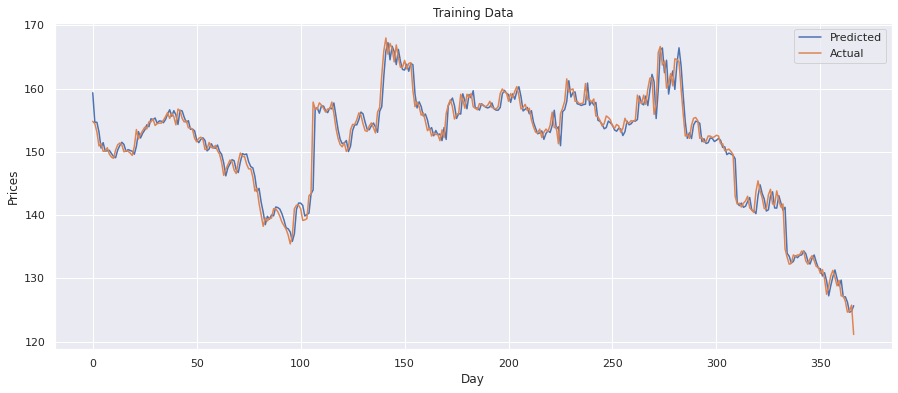

In [35]:
plt.figure(figsize = (15, 6))
plt.plot(model.predict(X_train), label='Predicted')
plt.plot(y_train, label='Actual')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.title('Training Data')
plt.show()

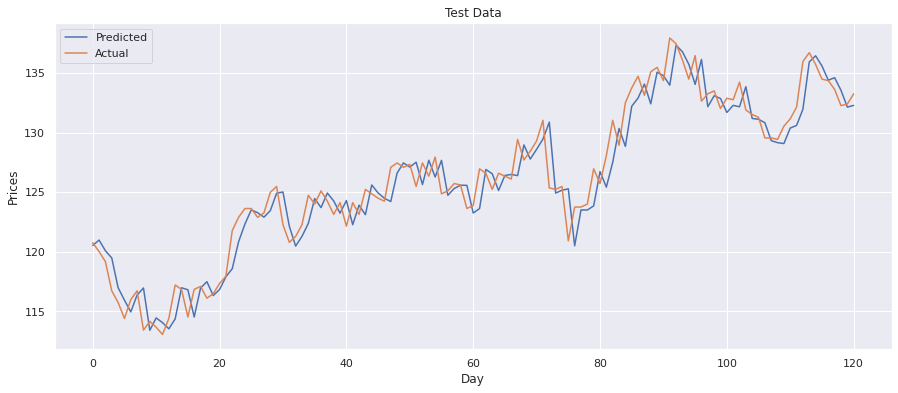

In [36]:
plt.figure(figsize = (15, 6))
plt.plot(pred, label='Predicted')
plt.plot(y_test, label='Actual')
plt.xlabel('Day')
plt.ylabel('Prices')
plt.legend()
plt.title('Test Data')
plt.show()

The predictions tend to be a little lagged, but the MSE and R2 scores seem to be acceptable. Assuming the same model building process would work well on other stocks as well, I proceed with the iteration for the next step.

## Iteration

There is one more step here in addition to the steps in the modeling section:
- Re-train the model on the entire dataset(training+test) in the hopes of achieving even higher accuracy and make predictions for the period from Day 505 to Day 756

In [37]:
models = [LinearRegression(),Lasso(),Ridge()]
model_names = ['LR','Lasso','Ridge']
paramlist = [{'fit_intercept':[True]}, 
             {'alpha':[0.001,0.01,0.1,1,10], 'max_iter':[40000]},
             {'alpha':[0.001,0.01,0.1,1,10], 'max_iter':[40000]}]

In [38]:
pred_table = pd.DataFrame()
summary_table = pd.DataFrame()

for stock in stocklist:
    data = pd.read_csv('/content/drive/My Drive/3. USC/2. Spring 2020/DSO530 ML/project/raw data 17-19/'+stock+'.csv')
    
    # Feature Engineering
    data['MA5_lag'] = data['Close'].shift(1).rolling(5).mean()
    data['MA15_lag'] = data['Close'].shift(1).rolling(15).mean()
    data['PROC_lag'] = (data['Close'].shift(1) - data['Close'].shift(2)) / data['Close'].shift(2)
    data['day5Return_lag'] = (data['Close'].shift(1) - data['Close'].shift(5)) / data['Close'].shift(5)
    data['day15Return_lag'] = (data['Close'].shift(1) - data['Close'].shift(15)) / data['Close'].shift(15)

    temp = pd.DataFrame(data['Close'].pct_change())
    temp['close_lag'] = temp['Close'].shift(1)
    temp['ups'] = np.where(temp['close_lag']>0, temp['close_lag'], 0)
    temp['downs'] = np.where(temp['close_lag']<0, temp['close_lag'].abs(), 0)
    RS = (temp.ups.shift(1).rolling(13).mean()*13 + temp.ups) / (temp.downs.shift(1).rolling(13).mean()*13 + temp.downs)
    data['rsi_lag'] = 100 - 100/(1+RS)

    temp = pd.DataFrame(data['Close'].shift(1)).rename(columns={'Close':'close_lag'})
    temp['low_lag'] = data['Low'].shift(1)
    temp['high_lag'] = data['High'].shift(1)
    data['fastK_lag'] = (temp.close_lag - temp.low_lag.rolling(14).min()) / (temp.high_lag.rolling(14).max() - temp.low_lag.rolling(14).min())
    data['fastD_lag'] = data['fastK_lag'].rolling(3).mean()

    temp['vol_lag'] = data['Volume'].shift(1)
    clv = ((temp.close_lag - temp.low_lag) - (temp.high_lag - temp.close_lag)) / (temp.high_lag - temp.low_lag)
    clv = np.where(clv.isna()==True, 0, clv)
    data['AD_lag'] = clv*temp.vol_lag

    temp['vol_lag2'] = data['Volume'].shift(2)
    temp['close_lag2'] = data['Close'].shift(2)
    temp['cond'] = np.where(temp.close_lag==temp.close_lag2, 0, 
                            np.where(temp.close_lag>temp.close_lag2, temp.vol_lag, -temp.vol_lag))
    data['OBV_lag'] = pd.Series([0,0]+temp['cond'][2:].tolist()).cumsum()

    for col in data.columns[1:6]:
        data[col+'_lag'] = data[col].shift(1)
        if col != 'Close':
            data.drop(columns=col, inplace=True)
    
    data = data[16:].reset_index(drop=True)

    # Train-test split
    end_day = data[data.Time=='Day504'].index[0]+1
    split_day = int(end_day*.75)+1
    training_data = data.iloc[:split_day,:].reset_index(drop=True)
    testing_data = data.iloc[split_day:end_day,:].reset_index(drop=True)
    oot_data = data.iloc[end_day:,:].reset_index(drop=True)

    y_train = training_data['Close']
    y_test = testing_data['Close']
    y_oot = oot_data['Close']
    X_train = training_data.drop(columns=['Time','Close'])
    X_test = testing_data.drop(columns=['Time','Close'])
    X_oot = oot_data.drop(columns=['Time','Close'])

    # Z-scaling
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    max_score = -100
    temp = pd.DataFrame(index=model_names,columns=['score'])
    for idx, name in enumerate(models):
        gridsearch = GridSearchCV(name, paramlist[idx], scoring='neg_root_mean_squared_error')
        gridsearch.fit(X_train, y_train)
        bestparam = gridsearch.best_params_
        bestscore = gridsearch.best_score_
        if bestscore > max_score:
            max_score, model_param = bestscore, bestparam
            model, model_name = name, model_names[idx]
    
    # Retraining on the whole training set
    model.set_params(**model_param)
    model.fit(X_train, y_train)
    
    summary_table.loc[stock,'best_model'] = model_name
    summary_table.loc[stock,'MSE_train'] = mean_squared_error(y_train, model.predict(X_train))
    summary_table.loc[stock,'R2_train'] = r2_score(y_train, model.predict(X_train))
    summary_table.loc[stock,'MSE_test'] = mean_squared_error(y_test, model.predict(X_test))
    summary_table.loc[stock,'R2_test'] = r2_score(y_test, model.predict(X_test))

    # Retraining on the whole dataset(training+test)
    data_trt = data.iloc[:end_day,:].reset_index(drop=True)
    y_trt = data_trt['Close']
    X_trt = data_trt.drop(columns=['Time','Close'])
    scaler = StandardScaler()
    X_trt = pd.DataFrame(scaler.fit_transform(X_trt), columns=X_trt.columns)
    X_oot = pd.DataFrame(scaler.transform(X_oot), columns=X_oot.columns)
    model.fit(X_trt, y_trt)
    pred = model.predict(X_oot)
    
    pred_table[stock+'_true'] = y_oot
    pred_table[stock+'_predict'] = pred
    summary_table.loc[stock,'MSE_oot'] = mean_squared_error(y_oot, pred)
    summary_table.loc[stock,'R2_oot'] = r2_score(y_oot, pred)

In [39]:
summary_table.head()

,best_model,MSE_train,R2_train,MSE_test,R2_test,MSE_oot,R2_oot
SH600000,Lasso,2.930437,0.964453,3.020212,0.923013,3.793888,0.965153
SH600010,Lasso,0.113562,0.979846,0.083943,0.608555,0.078977,0.965122
SH600015,Lasso,0.178823,0.951984,0.246179,0.775781,0.127715,0.937652
SH600016,Lasso,2.897718,0.965544,3.443620,0.829596,1.964804,0.952426
SH600018,Lasso,0.027129,0.975772,0.016841,0.912410,0.059537,0.959942


In [40]:
# Average performance
summary_table.mean()

MSE_train    160.652995
R2_train       0.973050
MSE_test     325.326808
R2_test        0.827406
MSE_oot      402.652086
R2_oot         0.944792
dtype: float64

In [41]:
pred_table

,SH600000_true,SH600000_predict,SH600010_true,SH600010_predict,SH600015_true,SH600015_predict,SH600016_true,SH600016_predict,SH600018_true,SH600018_predict,SH600028_true,SH600028_predict,SH600030_true,SH600030_predict,SH600036_true,SH600036_predict,SH600048_true,SH600048_predict,SH600050_true,SH600050_predict,SH600089_true,SH600089_predict,SH600104_true,SH600104_predict,SH600109_true,SH600109_predict,SH600111_true,SH600111_predict,SH600150_true,SH600150_predict,SH600256_true,SH600256_predict,SH600406_true,SH600406_predict,SH600518_true,SH600518_predict,SH600519_true,SH600519_predict,SH600583_true,SH600583_predict,...,SH601166_true,SH601166_predict,SH601169_true,SH601169_predict,SH601186_true,SH601186_predict,SH601288_true,SH601288_predict,SH601318_true,SH601318_predict,SH601328_true,SH601328_predict,SH601390_true,SH601390_predict,SH601398_true,SH601398_predict,SH601601_true,SH601601_predict,SH601628_true,SH601628_predict,SH601668_true,SH601668_predict,SH601688_true,SH601688_predict,SH601766_true,SH601766_predict,SH601800_true,SH601800_predict,SH601818_true,SH601818_predict,SH601857_true,SH601857_predict,SH601901_true,SH601901_predict,SH601988_true,SH601988_predict,SH601989_true,SH601989_predict,SH601998_true,SH601998_predict
0,131.0422,133.065762,13.0376,13.188836,32.4801,33.077128,145.4577,146.935948,7.2766,7.496075,17.0232,17.184814,89.7523,91.690054,135.4195,137.896228,256.1322,263.476713,8.1916,8.329123,256.7878,261.666072,217.6607,219.863778,62.8148,64.490188,182.5661,188.245358,43.5061,43.141537,169.7521,173.867238,498.2342,494.444034,489.2847,488.426431,4061.0330,4116.809672,105.2726,106.412186,...,62.6960,63.332058,19.2439,19.353210,14.1148,14.369098,5.3285,5.368753,145.6450,148.720597,10.0568,10.161112,8.4074,8.560573,9.1309,9.236559,37.8640,38.817544,25.4589,25.923047,10.9538,10.943376,19.6981,20.391517,11.1686,11.370145,15.0431,15.120545,5.2333,5.286700,10.0654,10.104458,5.3911,5.550787,6.1756,6.212190,7.0863,7.222601,7.8668,7.959835
1,133.0164,130.915916,13.1211,13.077081,32.3516,32.481859,144.7243,145.636007,7.3176,7.310952,17.2544,17.067698,91.0476,90.276124,135.2283,135.698203,256.1322,256.011470,8.2229,8.215530,257.5278,256.298637,221.0053,218.687235,63.0722,62.647093,182.3704,184.281069,43.9983,43.967657,166.4399,170.534884,495.3190,495.949234,476.6928,493.776713,4044.3221,4067.287875,104.4914,105.672229,...,62.9740,62.829865,19.4061,19.259849,14.3415,13.972843,5.3434,5.339719,144.0695,145.749817,10.0743,10.065386,8.5100,8.442687,9.1650,9.141142,38.2376,37.899389,25.7820,25.515889,11.2201,10.948292,19.8139,19.695165,11.1449,11.204548,15.2742,15.029402,5.2608,5.236627,10.1047,10.101391,5.4221,5.385873,6.2273,6.183424,7.1200,7.085806,7.8952,7.909453
2,130.4252,132.503395,13.0376,13.104292,32.3087,32.362408,143.0130,145.082964,7.2902,7.329455,16.7920,17.291395,94.1239,90.940672,133.4118,135.645251,246.8721,256.147992,8.1916,8.247011,253.8277,256.265501,220.0371,221.644321,62.8148,62.768430,181.3920,182.706832,44.8185,44.036760,165.6118,167.334777,493.9939,492.814504,474.4443,477.388065,4047.1986,4046.987763,103.9054,104.151350,...,62.1798,63.061650,19.2439,19.416554,13.9716,14.241992,5.2986,5.345890,143.0820,144.281091,9.9692,10.079007,8.3733,8.535673,9.1309,9.173235,37.5900,38.471762,25.6145,25.854188,11.0603,11.212752,19.3620,19.802044,11.0262,11.150279,15.0674,15.267561,5.2058,5.262544,9.9869,10.119821,5.3808,5.403790,6.1928,6.227322,7.1200,7.097424,7.8243,7.934178
3,130.0550,130.296729,12.9540,13.028829,32.0945,32.303642,142.2796,143.385708,7.2902,7.318140,16.3295,16.830474,94.9874,94.180925,127.9626,133.890497,245.4929,246.593157,8.1447,8.207685,252.3477,252.178370,224.4379,221.865565,63.0722,62.438447,179.8266,181.824015,44.5889,45.002242,161.8855,166.028396,485.7783,491.726161,474.4443,476.549772,3957.2060,4048.324842,102.3429,103.692416,...,61.3857,62.323817,19.2439,19.265706,13.8762,13.903671,5.2688,5.294812,141.3654,143.303775,10.0042,9.980072,8.3049,8.403712,9.0968,9.135848,37.5651,37.635829,25.7939,25

In [42]:
summary_table.to_csv('/content/drive/My Drive/Colab Notebooks/Algorithmic Trading/summary.csv')
pred_table.to_csv('/content/drive/My Drive/Colab Notebooks/Algorithmic Trading/prediction.csv')

In [43]:
print(datetime.now()-start_time)

0:02:24.740174
